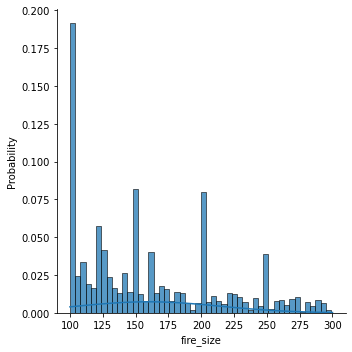

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.stats.distributions as dstr
import seaborn as sns
from typing import Callable
import math
import numpy as np
import random

df = pd.read_csv('../data/FW_Veg_Rem_Combined.csv')

df = df.loc[df.fire_size_class == 'D']

params = stats.norm.fit(df['fire_size'])
x = np.linspace(100, 300, 50)
sns.displot(data=df, x='fire_size',  bins=50, stat='probability')
plt.plot(x, stats.norm.pdf(x, params[0], params[1]), label='expon')
plt.show()

In [2]:
def accept_reject(df: pd.DataFrame, property: str, dis: Callable, M: float):
    dis_params = dis.fit(df[property])
    df_sample = pd.DataFrame(columns=df.columns)
    df_size = df.shape[0]

    min_val = df[property].min()
    max_val = df[property].max()
    x = np.linspace(min_val, max_val, num=5000)

    ind = 0

    while ind < len(x) -1:
        min_s = x[ind]
        max_s = x[ind + 1]

        avg = (min_s + max_s) / 2
        sm = df.loc[(df[property] >= min_s) & (df[property] < max_s)]
        prob_current = M * sm.shape[0]/df_size
        prob_needed = dis.pdf(avg, dis_params[0], dis_params[1])

        r_m = random.random()

        if r_m <= (prob_needed/prob_current):
            df_sample = df_sample.append(sm)
    
        ind += 1
    return df_sample

def pps(df: pd.DataFrame, property: str, size_f: float) -> pd.DataFrame:
    fire_size_total = df[property].sum()
    sample_size = int(df.size * size_f)

    df['cumulative_sum'] = df[property].cumsum()
    interval_width = int(fire_size_total/sample_size)

    num = interval_width #can be a random number also as in the example

    sampled_series = np.arange(num, fire_size_total, interval_width)
    cum_array = np.asarray(df['cumulative_sum'])
    idx = np.searchsorted(cum_array, sampled_series) #the heart of code
    result = cum_array[idx-1] 
    ndf = df[df.cumulative_sum.isin(result)]
    del ndf['cumulative_sum'] #so that new file doesn't have cum_sum column
    return ndf

/tmp/ipykernel_235679/1211688567.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  if r_m <= (prob_needed/prob_current):


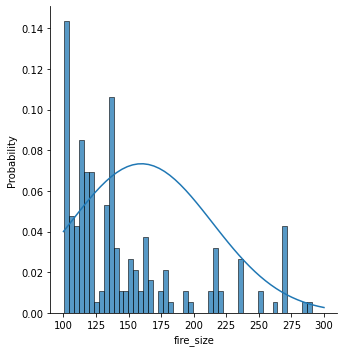

In [3]:
M = 10
df_a = accept_reject(df, 'fire_size', dstr.expon, M)

sns.displot(data=df_a, x='fire_size',  bins=50, stat='probability')
plt.plot(x, M * stats.norm.pdf(x, params[0], params[1]), label='expon')
plt.show()

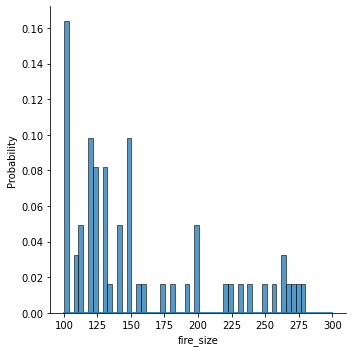

In [10]:
M = 0.001
df_a = pps(df, 'fire_size', M)

sns.displot(data=df_a, x='fire_size',  bins=50, stat='probability')
plt.plot(x, M * stats.norm.pdf(x, params[0], params[1]), label='expon')
plt.show()